In [1]:
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
columns = ['featgentime', 'Zcross12', 'Zcross13', 'Zcross23', 'maxj', 'maxk', 'maxi1', 'maxi2', 'maxstrength', 'secondres', 'tlyap']
for i, s in zip([0,2], ['12', '23']): # take adjacent ones
    columns += ['EMmed'+s, 'EMmax'+s, 'EMdrift'+s, 'capseculartscale'+s, 'EMdetrendedstd'+s, 'EMrollingstd'+s, 'DiffcoeffEM'+s, 'medvarEM'+s, 'Zmed'+s, 'Zmax'+s, 'Zdetrendedstd'+s, 'Zrollingstd'+s, 'DiffcoeffZ'+s, 'medvarZ'+s, 'Zcomdrift'+s, 'Zcomrollingstd'+s, 'phiZcomdrift'+s, 'phiZcomrollingstd'+s, 'Zstardrift'+s, 'Zstarrollingstd'+s, 'Zcosphistd'+s, 'medZcosphi'+s]

# Skip this section. This is to format and join the new dataset with the old one. You can just load the final csv below. Use this to regenerate if you want and have access to the files on CITA

In [200]:
df = pd.read_csv('/mnt/raid-cita/dtamayo/newstabilitydataset/data/csvs/data.csv', index_col=0)
df['SimID'] = np.arange(df.shape[0])
df['Stable'] = df['instability_time'] >= 9.99e8
df = df[['SimID', 'Stable']]
df.set_index('SimID', inplace=True)
df.tail()

,Stable
SimID,
9995,True
9996,False
9997,False
9998,False
9999,False


In [201]:
dff = pd.read_csv('../../csvs/resshortfeatures.csv', index_col=0)
del dff['runstring']
del dff['featgentime']
dff.tail()

,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,tlyap,...,DiffcoeffZ23,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23
SimID,,,,,,,,,,,,,,,,,,,,,
9995,0.160673,0.603900,0.381870,5.0,1.0,1.0,2.0,0.361500,0.015648,16014.670197,...,2.948659e-09,0.000008,0.030713,0.004626,0.100482,0.003975,0.031589,0.003456,0.056012,0.000215
9996,0.052687,0.525926,0.449554,27.0,2.0,1.0,2.0,0.000380,0.111747,56144.959422,...,-4.845470e-11,0.000004,0.386751,0.032375,5.882195,0.039279,0.000000,0.000000,0.006654,-0.000014
9997,0.084531,0.206673,0.112622,4.0,1.0,1.0,3.0,0.007938,0.429958,126.809024,...,7.329326e-07,0.006643,0.884267,0.154314,1.528973,0.217228,8.763043,1.017298,0.243900,-0.019435
9998,0.284352,0.365163,0.062919,3.0,1.0,1.0,2.0,0.000939,0.930229,92200.343558,...,3.538395e-09,0.000067,0.169636,0.005230,0.382835,0.011517,0.034858,0.006005,0.105414,0.006507
9999,0.129620,0.389971,0.230476,6.0,1.0,1.0,2.0,0.046137,0.025062,222197.654727,...,1.570898e-08,0.003621,3.935178,0.275869,0.756752,0.091269,1.592176,0.264800,0.112955,-0.003568


In [202]:
df = pd.concat([df, dff], axis=1)

In [203]:
df.tail()

,Stable,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,DiffcoeffZ23,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23
SimID,,,,,,,,,,,,,,,,,,,,,
9995,True,0.160673,0.603900,0.381870,5.0,1.0,1.0,2.0,0.361500,0.015648,...,2.948659e-09,0.000008,0.030713,0.004626,0.100482,0.003975,0.031589,0.003456,0.056012,0.000215
9996,False,0.052687,0.525926,0.449554,27.0,2.0,1.0,2.0,0.000380,0.111747,...,-4.845470e-11,0.000004,0.386751,0.032375,5.882195,0.039279,0.000000,0.000000,0.006654,-0.000014
9997,False,0.084531,0.206673,0.112622,4.0,1.0,1.0,3.0,0.007938,0.429958,...,7.329326e-07,0.006643,0.884267,0.154314,1.528973,0.217228,8.763043,1.017298,0.243900,-0.019435
9998,False,0.284352,0.365163,0.062919,3.0,1.0,1.0,2.0,0.000939,0.930229,...,3.538395e-09,0.000067,0.169636,0.005230,0.382835,0.011517,0.034858,0.006005,0.105414,0.006507
9999,False,0.129620,0.389971,0.230476,6.0,1.0,1.0,2.0,0.046137,0.025062,...,1.570898e-08,0.003621,3.935178,0.275869,0.756752,0.091269,1.592176,0.264800,0.112955,-0.003568


In [204]:
df1 = pd.read_csv('../../csvs/randomshortfeatures.csv', index_col=0)
del df1['runstring']
del df1['featgentime']
df1.tail()

,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,tlyap,...,DiffcoeffZ23,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23
SimID,,,,,,,,,,,,,,,,,,,,,
24995,0.171907,0.387978,0.184376,9.0,2.0,2.0,3.0,0.003431,0.145552,3.973561e+01,...,1.745551e-06,0.000717,0.060754,0.005449,0.016285,0.002086,0.084769,0.001440,0.367484,0.084805
24996,0.118284,0.220488,0.091394,8.0,1.0,2.0,3.0,0.006414,0.106497,1.126727e+02,...,4.867103e-07,0.002863,1.386549,0.311781,6.123500,2.000274,0.752978,0.014807,0.123352,-0.057720
24997,0.579004,0.697671,0.075153,2.0,1.0,1.0,2.0,0.019195,0.301054,2.460738e+03,...,-1.135500e-07,0.001531,0.053027,0.011746,0.574987,0.021306,1.199827,0.018510,0.096530,-0.112411
24998,0.055424,0.286817,0.219241,4.0,1.0,2.0,3.0,0.003782,0.788378,-4.192042e+04,...,1.357478e-08,0.000079,0.125268,0.004959,0.336359,0.010575,9.060472,0.015823,0.091789,0.004391
24999,0.316695,0.849302,0.404503,3.0,1.0,1.0,2.0,0.002190,0.152994,-2.683951e+06,...,1.085541e-11,0.000023,0.210186,0.039263,0.573982,0.045580,0.208377,0.003629,0.008251,0.000276


In [205]:
df2 = pd.read_csv("../../csvs/BetaFeats/sifOrbsMore=10000.0Nout=100window=10.csv", index_col = 0)
df2.index.name='SimID'
df2 = df2['Stable']
df2.tail()

SimID
24995    0.0
24996    0.0
24997    0.0
24998    0.0
24999    1.0
Name: Stable, dtype: float64

In [206]:
print(df1.shape, df2.shape)

((25000, 54), (24999,))


In [207]:
df2 = pd.concat([df2, df1], axis=1)
df2 = df2.drop(df2.index[11003]) # missing stability
df2.tail()

,Stable,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,DiffcoeffZ23,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23
SimID,,,,,,,,,,,,,,,,,,,,,
24995,0.0,0.171907,0.387978,0.184376,9.0,2.0,2.0,3.0,0.003431,0.145552,...,1.745551e-06,0.000717,0.060754,0.005449,0.016285,0.002086,0.084769,0.001440,0.367484,0.084805
24996,0.0,0.118284,0.220488,0.091394,8.0,1.0,2.0,3.0,0.006414,0.106497,...,4.867103e-07,0.002863,1.386549,0.311781,6.123500,2.000274,0.752978,0.014807,0.123352,-0.057720
24997,0.0,0.579004,0.697671,0.075153,2.0,1.0,1.0,2.0,0.019195,0.301054,...,-1.135500e-07,0.001531,0.053027,0.011746,0.574987,0.021306,1.199827,0.018510,0.096530,-0.112411
24998,0.0,0.055424,0.286817,0.219241,4.0,1.0,2.0,3.0,0.003782,0.788378,...,1.357478e-08,0.000079,0.125268,0.004959,0.336359,0.010575,9.060472,0.015823,0.091789,0.004391
24999,1.0,0.316695,0.849302,0.404503,3.0,1.0,1.0,2.0,0.002190,0.152994,...,1.085541e-11,0.000023,0.210186,0.039263,0.573982,0.045580,0.208377,0.003629,0.008251,0.000276


In [208]:
df2[df2['Stable'].isnull()]

,Stable,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,DiffcoeffZ23,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23
SimID,,,,,,,,,,,,,,,,,,,,,


In [209]:
df2.shape

(24999, 55)

In [210]:
dffull = df.append(df2)
dffull.shape

(34999, 55)

In [211]:
dffull.head()

,Stable,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,DiffcoeffZ23,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23
SimID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.504063,0.594658,0.060234,12.0,1.0,2.0,3.0,0.048244,0.195509,...,-5.249295e-10,1.471706e-04,0.022954,0.000753,0.144779,0.004245,0.167833,0.001449,0.013174,-0.342356
1,1.0,0.240504,0.340424,0.080547,9.0,1.0,2.0,3.0,0.020943,0.032165,...,1.420017e-09,9.234751e-05,0.037671,0.001800,0.050951,0.002006,0.027171,0.000309,0.069005,-0.684871
2,1.0,0.129660,1.261558,1.001981,6.0,1.0,1.0,2.0,0.067762,0.029946,...,9.176673e-11,3.508728e-07,0.427300,0.013722,0.662545,0.019659,0.004258,0.001175,0.020689,0.000014
3,0.0,0.406112,1.007603,0.427768,5.0,2.0,1.0,2.0,0.045905,0.053205,...,5.512634e-08,3.856095e-04,0.837207,0.054084,0.949622,0.048041,0.000000,0.000000,0.081755,0.001596
4,0.0,0.059897,0.332922,0.257596,12.0,1.0,1.0,2.0,0.030171,0.140455,...,-5.059799e-09,1.147590e-03,4.493881,0.296834,5.268717,0.106801,0.000000,0.012919,0.082736,0.000399


In [212]:
dffull.to_csv('../../csvs/joinedshortfeatures.csv', encoding='ascii')

In [7]:
df = pd.read_csv('../../csvs/joinedshortfeatures.csv', index_col=0)
print(df.shape)
df.head()

(34999, 69)


,Stable,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,EMrollingstd,DiffcoeffEM,Zcomdrift,Zcomrollingstd,phiZcomdrift,phiZcomrollingstd,Zstardrift,Zstarrollingstd,Zcosphistd,medZcosphi
SimID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.504063,0.594658,0.060234,12.0,1.0,2.0,3.0,0.048244,0.195509,...,0.059176,-2.929418e-09,0.022954,0.000753,0.144779,0.004245,0.167833,0.001449,0.013174,-0.342356
1,1.0,0.240504,0.340424,0.080547,9.0,1.0,2.0,3.0,0.020943,0.032165,...,0.007753,7.078889e-09,0.037671,0.001800,0.050951,0.002006,0.027171,0.000309,0.069005,-0.684871
2,1.0,0.129660,1.261558,1.001981,6.0,1.0,1.0,2.0,0.067762,0.029946,...,0.086955,5.797626e-09,0.073804,0.002971,0.905610,0.026282,0.082596,0.005669,0.003088,-0.197488
3,0.0,0.406112,1.007603,0.427768,5.0,2.0,1.0,2.0,0.045905,0.053205,...,0.081110,1.023791e-07,0.025712,0.000759,0.329220,0.009570,0.280508,0.003311,0.019143,-0.020344
4,0.0,0.059897,0.332922,0.257596,12.0,1.0,1.0,2.0,0.030171,0.140455,...,0.055239,-3.428641e-08,0.152660,0.022211,5.224163,0.185585,0.272027,0.050600,0.022942,-0.281169


In [4]:
newfeatures = ['EMmed', 'EMmax', 'EMdrift', 'EMdetrendedstd', 'EMrollingstd', 'DiffcoeffEM', 'Zcomdrift', 'Zcomrollingstd', 'phiZcomdrift', 'phiZcomrollingstd', 'Zstardrift', 'Zstarrollingstd', 'Zcosphistd', 'medZcosphi']

In [5]:
for f in newfeatures:
    df[f] = 0
print(df.shape)
df.head()

(34999, 69)


,Stable,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,EMrollingstd,DiffcoeffEM,Zcomdrift,Zcomrollingstd,phiZcomdrift,phiZcomrollingstd,Zstardrift,Zstarrollingstd,Zcosphistd,medZcosphi
SimID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.504063,0.594658,0.060234,12.0,1.0,2.0,3.0,0.048244,0.195509,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.240504,0.340424,0.080547,9.0,1.0,2.0,3.0,0.020943,0.032165,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.129660,1.261558,1.001981,6.0,1.0,1.0,2.0,0.067762,0.029946,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.406112,1.007603,0.427768,5.0,2.0,1.0,2.0,0.045905,0.053205,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.059897,0.332922,0.257596,12.0,1.0,1.0,2.0,0.030171,0.140455,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def takeone(row):
    s = '12' if row['Zcross12'] < row['Zcross23'] else '23'
    row['EMmed'] = row['EMmed'+s]
    row['EMmax'] = row['EMmax'+s]
    row['EMdrift'] = row['EMdrift'+s]
    row['EMdetrendedstd'] = row['EMdetrendedstd'+s]
    row['EMrollingstd'] = row['EMrollingstd'+s]
    row['DiffcoeffEM'] = row['DiffcoeffEM'+s]
    row['Zcomdrift'] = row['Zcomdrift'+s]
    row['Zcomrollingstd'] = row['Zcomrollingstd'+s]
    row['phiZcomdrift'] = row['phiZcomdrift'+s]
    row['phiZcomrollingstd'] = row['phiZcomrollingstd'+s]
    row['Zstardrift'] = row['Zstardrift'+s]
    row['Zstarrollingstd'] = row['Zstarrollingstd'+s]
    row['Zcosphistd'] = row['Zcosphistd'+s]
    row['medZcosphi'] = row['medZcosphi'+s]
    return row

In [376]:
%%time
df = df.apply(takeone, axis=1)
print(df.shape)
df.head()

(34999, 69)
CPU times: user 17.1 s, sys: 77 ms, total: 17.2 s
Wall time: 17.8 s


In [377]:
df.to_csv('../../csvs/joinedshortfeatures.csv', encoding='ascii')

# Start here with the new dataset (joinedshortfeatures.csv)

In [3]:
df = pd.read_csv('../../csvs/joinedshortfeatures.csv', index_col=0)
print(df.shape)
df.head()

(34999, 69)


,Stable,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,EMrollingstd,DiffcoeffEM,Zcomdrift,Zcomrollingstd,phiZcomdrift,phiZcomrollingstd,Zstardrift,Zstarrollingstd,Zcosphistd,medZcosphi
SimID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.504063,0.594658,0.060234,12.0,1.0,2.0,3.0,0.048244,0.195509,...,0.059176,-2.929418e-09,0.022954,0.000753,0.144779,0.004245,0.167833,0.001449,0.013174,-0.342356
1,1.0,0.240504,0.340424,0.080547,9.0,1.0,2.0,3.0,0.020943,0.032165,...,0.007753,7.078889e-09,0.037671,0.001800,0.050951,0.002006,0.027171,0.000309,0.069005,-0.684871
2,1.0,0.129660,1.261558,1.001981,6.0,1.0,1.0,2.0,0.067762,0.029946,...,0.086955,5.797626e-09,0.073804,0.002971,0.905610,0.026282,0.082596,0.005669,0.003088,-0.197488
3,0.0,0.406112,1.007603,0.427768,5.0,2.0,1.0,2.0,0.045905,0.053205,...,0.081110,1.023791e-07,0.025712,0.000759,0.329220,0.009570,0.280508,0.003311,0.019143,-0.020344
4,0.0,0.059897,0.332922,0.257596,12.0,1.0,1.0,2.0,0.030171,0.140455,...,0.055239,-3.428641e-08,0.152660,0.022211,5.224163,0.185585,0.272027,0.050600,0.022942,-0.281169


# Choose what features you want to use for training

In [5]:
features = []
#features += ['Zcross12', 'Zcross13', 'Zcross23']
features += ['maxstrength']#, 'secondres']
features += ['tlyap']
features += ['EMmax']#, 'EMdrift']#'EMmed'
features += ['EMdetrendedstd']
#features += ['EMrollingstd'+s]
features += ['DiffcoeffEM']#, 'medvarEM'+s]
#features += ['Zmed'+s, 'Zmax'+s]
#features += ['Zdetrendedstd'+s]
#features += ['Zrollingstd'+s]
#features += ['DiffcoeffZ'+s, 'medvarZ'+s]
features += ['Zstarrollingstd']#'Zstardrift', 
#features += ['Zcomdrift', 'Zcomrollingstd', 'phiZcomdrift', 'phiZcomrollingstd', 'Zstardrift', 'Zstarrollingstd']
#features += ['Zcosphistd', 'medZcosphi']


#for i, s in zip([0,2], ['12', '23']): # take adjacent ones
#    features += ['EMmed'+s, 'EMmax'+s, 'EMdrift'+s]
#    features += ['EMdetrendedstd'+s]
#    #features += ['EMrollingstd'+s]
#    features += ['DiffcoeffEM'+s]#, 'medvarEM'+s]
#    #features += ['Zmed'+s, 'Zmax'+s]
#    #features += ['Zdetrendedstd'+s]
#    #features += ['Zrollingstd'+s]
#    #features += ['DiffcoeffZ'+s, 'medvarZ'+s]
#    features += ['Zcomdrift'+s, 'Zcomrollingstd'+s, 'phiZcomdrift'+s, 'phiZcomrollingstd'+s, 'Zstardrift'+s, 'Zstarrollingstd'+s]
#    features += ['Zcosphistd'+s, 'medZcosphi'+s]

y = df['Stable']
X = df[features]
X.head()

,maxstrength,tlyap,EMmax,EMdetrendedstd,DiffcoeffEM,Zstarrollingstd
SimID,,,,,,
0,0.048244,-1.258035e+06,0.544886,0.059201,-2.929418e-09,0.001449
1,0.020943,6.929478e+05,1.103609,0.013421,7.078889e-09,0.000309
2,0.067762,-1.243923e+05,0.339270,0.086699,5.797626e-09,0.005669
3,0.045905,-8.146903e+05,0.142481,0.083598,1.023791e-07,0.003311
4,0.030171,2.922120e+04,0.480884,0.062962,-3.428641e-08,0.050600


In [6]:
X.shape

(34999, 6)

In [7]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
xgbc = XGBClassifier(seed = 0)

In [9]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [10]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

In [11]:
%%time
trials = Trials()
#import time
#start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
#end = time.time()
#print("Optimization Time: %f seconds", (end  -start))

('SCORE:', 0.95550200000000007, 'ERROR', 0.005278843845300479, 'HOLDOUT SCORE', 0.95264170716718155)
('SCORE:', 0.95934668000000001, 'ERROR', 0.0035174575489503256, 'HOLDOUT SCORE', 0.95450330076847612)
('SCORE:', 0.95487273999999989, 'ERROR', 0.0057600355072347179, 'HOLDOUT SCORE', 0.95117676430955544)
('SCORE:', 0.95390520000000001, 'ERROR', 0.0056357233920793304, 'HOLDOUT SCORE', 0.9516887322821993)
('SCORE:', 0.96017727999999991, 'ERROR', 0.003241150771799014, 'HOLDOUT SCORE', 0.95641731129203222)
('SCORE:', 0.95317960000000002, 'ERROR', 0.0057340497331418187, 'HOLDOUT SCORE', 0.94919276177803846)
('SCORE:', 0.95553576000000007, 'ERROR', 0.0029412645560325944, 'HOLDOUT SCORE', 0.95093357621896191)
('SCORE:', 0.91998937999999997, 'ERROR', 0.010666091301956167, 'HOLDOUT SCORE', 0.93115248690546004)
('SCORE:', 0.95623007999999987, 'ERROR', 0.0038395009890830069, 'HOLDOUT SCORE', 0.94864493886865442)
('SCORE:', 0.95871063999999984, 'ERROR', 0.0038043494127664168, 'HOLDOUT SCORE', 0.953

In [12]:
#fit the smaller rage 
#{'x_learning_rate': 0.07419653015127085,
# 'x_max_depth': 8,
# 'x_min_child': 4.0,
# 'x_pos_weight': 8.889472764333366,
# 'x_subsample': 0.9380315392096068,
# 'x_tree_colsample': 0.734517699234413}

#{'x_learning_rate': 0.19890696372714528,
# 'x_max_depth': 17,
# 'x_min_child': 8.0,
# 'x_pos_weight': 12.505309968632893,
# 'x_subsample': 0.9409498631912948,
# 'x_tree_colsample': 0.7528946858805113}

best

{'x_learning_rate': 0.11725867007843385,
 'x_max_depth': 12,
 'x_min_child': 10.0,
 'x_pos_weight': 1.2083720410653807,
 'x_subsample': 0.9415659961327684,
 'x_tree_colsample': 0.9196237894002443}

In [13]:
#switch to the traditional 80 20 slipt, dont know why i did the 40 60 split before
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]



best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
#score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
#print score
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print score

0.964111445604


In [14]:
#try testing on the holdout set with these parameters
from sklearn.metrics import roc_auc_score

    
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

best_xgbc.fit(trainX, trainY)
preds = best_xgbc.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print auc_Score
print metrics.average_precision_score(testY, preds)

0.977652838518
0.965623501638


In [15]:
print best

{'x_pos_weight': 1.2083720410653807, 'x_learning_rate': 0.11725867007843385, 'x_max_depth': 12, 'x_min_child': 10.0, 'x_tree_colsample': 0.9196237894002443, 'x_subsample': 0.9415659961327684}


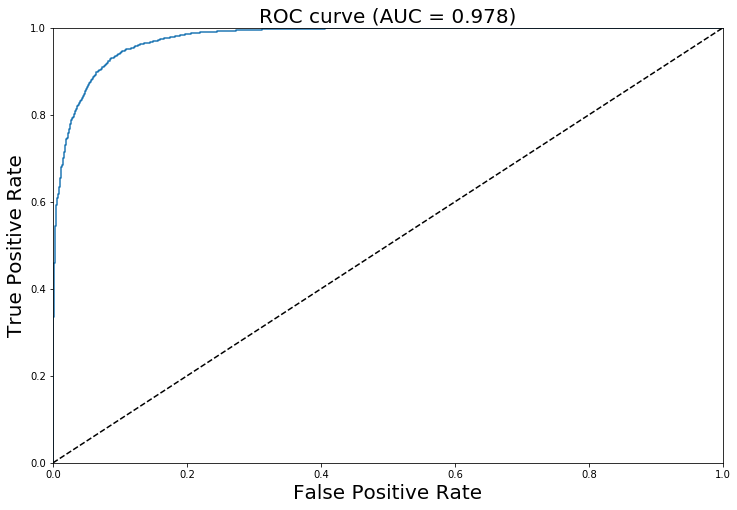

In [16]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)), fontsize=20)

In [17]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.00520906131715, recall = 1.0, precision = 0.567517496912
Threshold 0.00540798762813, recall = 0.999637286906, precision = 0.569068759034
Threshold 0.00552676152438, recall = 0.999637286906, precision = 0.570836785418
Threshold 0.00564751308411, recall = 0.999637286906, precision = 0.572615832121
Threshold 0.00583181064576, recall = 0.999637286906, precision = 0.574406002501
Threshold 0.00599955674261, recall = 0.999637286906, precision = 0.576207401213
Threshold 0.00611208332703, recall = 0.999637286906, precision = 0.578020134228
Threshold 0.00623244047165, recall = 0.999637286906, precision = 0.579844308858
Threshold 0.00643557170406, recall = 0.999637286906, precision = 0.58168003377
Threshold 0.0066168657504, recall = 0.999637286906, precision = 0.583527419013
Threshold 0.00681901862845, recall = 0.999274573812, precision = 0.585174171623
Threshold 0.0070341816172, recall = 0.999274573812, precision = 0.587044534413
Threshold 0.00714377686381, recall = 0.999274573812, p

AUC Score (Test): 0.965624


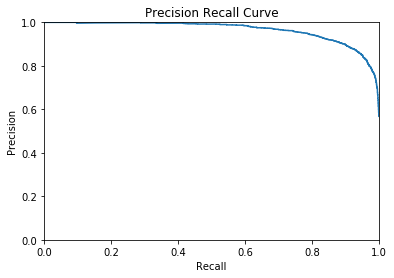

In [18]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print "AUC Score (Test): %f" % metrics.average_precision_score(testY, preds)
plt.show()

[ 0.27350095  0.88932282  0.99179852  0.99780935  0.99839455]
2757 4243
[ 2892.   289.   138.    99.    56.    50.    35.    31.    39.    40.
    26.    21.    15.    22.    28.    21.    14.    16.    13.    13.
    17.     9.    11.    17.    17.    17.    17.    10.    15.    15.
     9.    14.     8.     5.    13.    10.    11.    15.    13.    13.
    17.     6.    11.    18.     9.    17.    11.    19.    10.    11.]
[  10   10   12   12   11    9    7   12    9    6   10    8    7    8    9
    8   14    5   10    9   11    6   13   20   14   15   12   20   16   17
   22   21   16   18   25   20   17   28   30   41   34   32   50   67   65
   97  104  139  258 1075]


(0, 350)

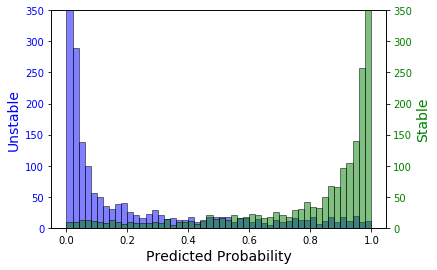

In [19]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print Stable[:5][:]
Unstable=preds[np.where(testY==0)]
print Stable.size, Unstable.size


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print n
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print n.astype(int)
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

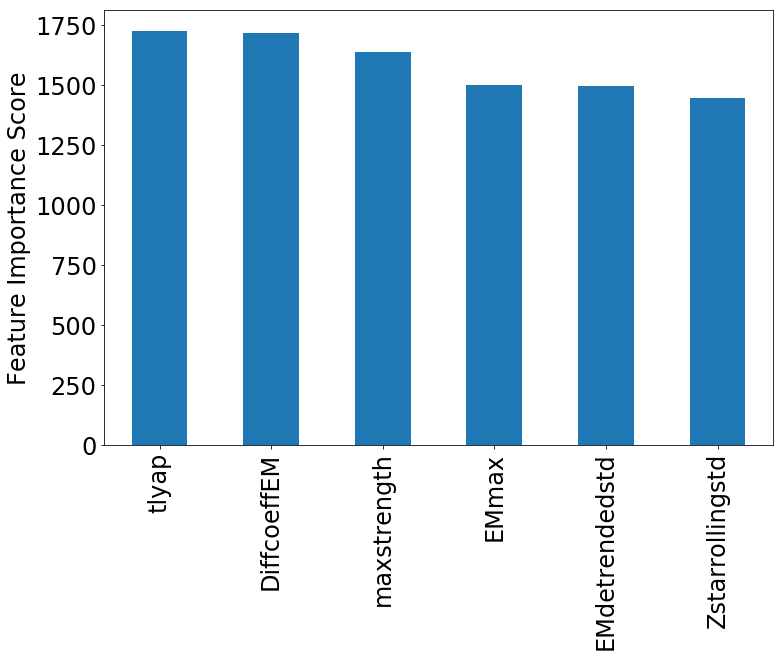

In [20]:
# feature importances
feat_imp = pd.Series(best_xgbc.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12,8), fontsize=24)
plt.ylabel('Feature Importance Score', fontsize=24)
plt.show()

In [21]:
import dill
dill.dump([best_xgbc, features] ,open("resmodel.pkl", 'wb'))